In [1]:
import dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

db = dataset.connect('sqlite:///results.db')
raw_data = db['eval_big'].all()
row_data = []
for i in raw_data:
    row_data.append((i['instance'], i['solver'], i['valid_result'], i['time_used']))

In [36]:
def data_wrangling(results):
    # solvers = [set(x[1]) for x in results]
    # instances = [set(x[0] for x in results)]

    df = pd.DataFrame(results,
                      columns=['instance', 'solver', 'valid', 'time'])

    return df

def plot_overview(df):
    #print(plt.style.available)
    #plt.style.use('seaborn-talk')
    f, axarr = plt.subplots(4, figsize=(25, 10))

    """ robustness -> heatmap """
    success = df.pivot('instance', 'solver', 'valid')
    sns.heatmap(success, cbar=False, cmap='RdYlGn', linewidths=.5, ax=axarr[0])
    axarr[0].set_title('Robustness-eval: objective valid within tol?')
    axarr[0].set_ylabel('Instance')
    axarr[0].set_xlabel('Solver')
    #axarr[0].yaxis.set_ticks_position('none')
    axarr[0].yaxis.set_major_locator(plt.NullLocator())

    """ robustness -> count """
    sns.barplot(x='solver', y='valid', data=df, estimator=sum, ci=None, ax=axarr[1])
    axarr[1].set_title('Robustness-eval: number of solved instances')
    axarr[1].set_ylabel('# Solved')
    axarr[1].set_xlabel('Solver')
    axarr[1].yaxis.set_major_locator(MaxNLocator(integer=True))

    """ absolute time -> barplot """
    # set time to zero if invalid => only for visualization
    df['time'] = df.apply(lambda row: 0 if not row['valid'] else row['time'], axis=1)
    sns.barplot(x="instance", y="time", hue="solver", data=df, ax=axarr[2])
    axarr[2].set_title('Performance-eval: absolute time used (logscale)')
    axarr[2].set_ylabel('Time (s)')
    axarr[2].set_xlabel('Instance')
    axarr[2].set_yscale("log")
    axarr[2].tick_params(axis='x', which='major', labelsize=10)
    
    """ relative time -> barplot """
    df['time'] /= df.groupby('instance')["time"].transform(max)
    sns.barplot(x="instance", y="time", hue="solver", data=df, ax=axarr[3])
    axarr[3].set_title('Performance-eval: relative time (to slowest) used')
    axarr[3].set_ylabel('Relative Time')
    axarr[3].set_xlabel('Instance')
    axarr[3].tick_params(axis='x', which='major', labelsize=10)

    plt.tight_layout()
    plt.savefig('eval.png', dpi=200)
    plt.show()

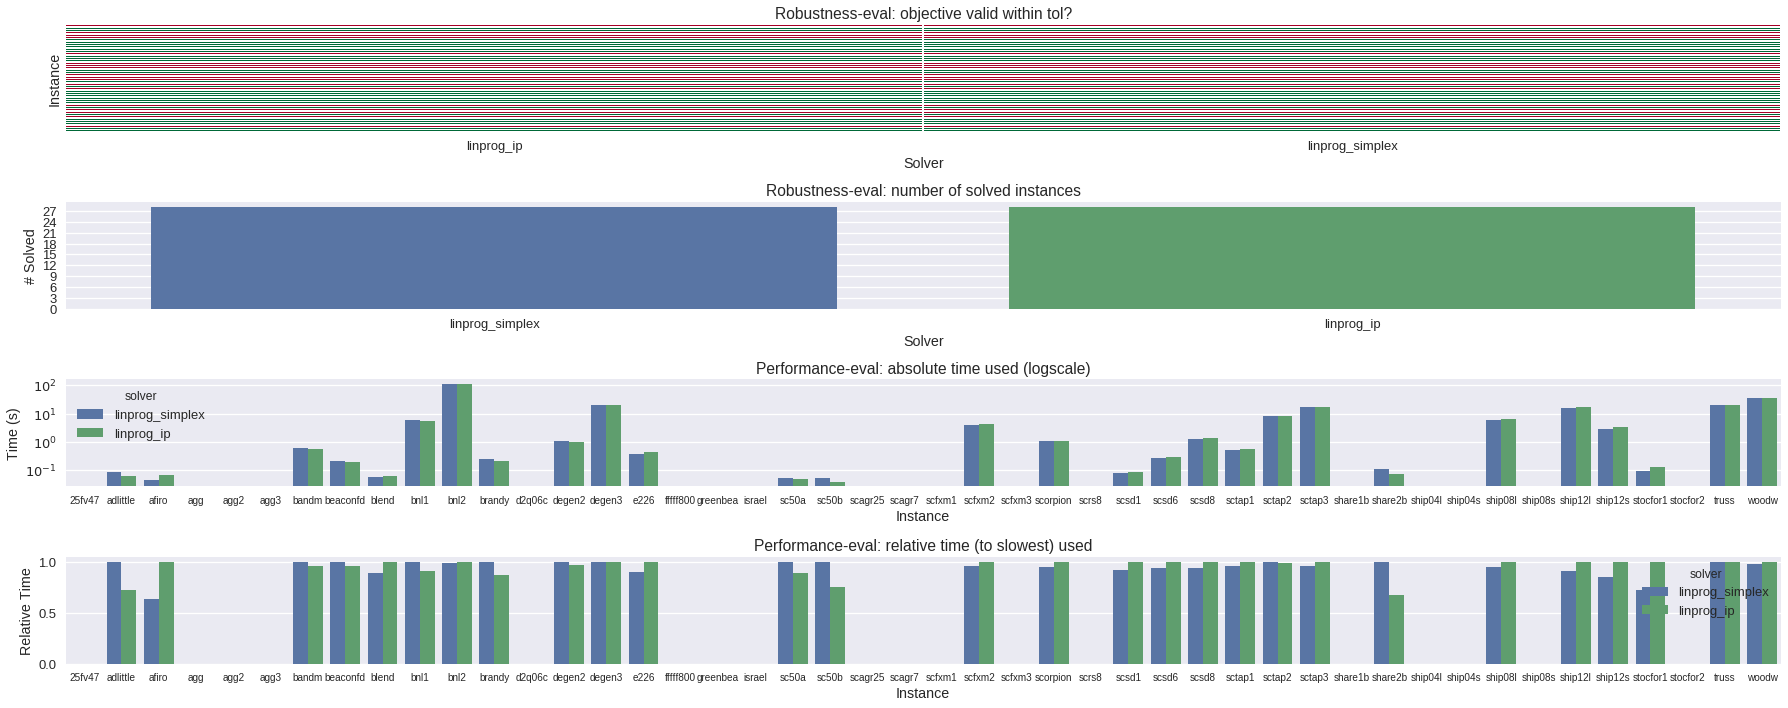

In [37]:
df = data_wrangling(row_data)
plot_overview(df)